# 函数库准备

In [10]:
import pymysql
import pandas as pd
import numpy as np
from itertools import groupby
from WindPy import w

import time
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import squarify
from pylab import *
import matplotlib.ticker as ticker     # 用于设置轴刻度密度
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 允许图中出现中文
plt.rcParams['axes.unicode_minus']=False      # 允许图中出现负号

from pptx import Presentation
from pptx import Presentation
from pptx.chart.data import ChartData
from pptx.enum.chart import XL_CHART_TYPE
from pptx.enum.chart import XL_LEGEND_POSITION
from pptx.enum.chart import XL_LABEL_POSITION
from pptx.util import Cm
from pptx.util import Pt
from pptx.dml.color import RGBColor

In [11]:
class mysql():   # mysql的初始化参数是数据库名称，输入字符串
    
    def __init__(self,database):   # mysql的初始化参数是数据库名称，输入字符串
        self.host='ks-pdze3vtt205wav0n25.mysql.polardb.rds.aliyuncs.com'
        self.user='ruqin'
        self.password='tfzq@2020'
        self.port=3306
        self.charset='utf8'
        self.database = database
        self.conn = self.connect()
        if(self.conn):
            self.cursor = self.conn.cursor()   
            
    def connect(self):       
        conn = False        
        try:            
            conn = pymysql.connect(host=self.host,
                                    port=self.port,
                                    user=self.user,
                                    passwd=self.password,
                                    db=self.database,
                                    charset=self.charset)
        except Exception as err:
            print("连接数据库失败, %s" % err)
        else:
            return conn
        
    #执行查询    
    def execute(self,sql,*args):  # sql是sql语句，code允许传入多个参数到sql中
        res = ""        
        try:            
            self.cursor.execute(sql,*args)            
            res = self.cursor.fetchall()        
        except Exception as err:            
            print("查询失败, %s" % err)        
        else:           
            return res

    # 关闭游标
    def close(self):
        self.cursor.close()

In [12]:
# 定义全局变量
global tradedays_daily
global tradedays_weekly
global today
global industry
global gl_tradedays_daily

# 连接交易日数据库
data_test_1 = mysql('tradedays')
sql='select * from `hs_tradedays_daily`'
tradedays_daily = pd.DataFrame(data_test_1.execute(sql))
sql='select * from `hs_tradedays_weekly`'
tradedays_weekly = pd.DataFrame(data_test_1.execute(sql))
sql='select * from `mix_ushk_tradedays_daily`'
gl_tradedays_daily = pd.DataFrame(data_test_1.execute(sql))
today = time.strftime('%Y%m%d', time.localtime())
ref_date = '20200424'

# 连接行业数据库
data_test = mysql('hs_index_zx1_daily')
sql = 'select code from `20200214`' 
industry = data_test.execute(sql)  # 获得所有行业指数的代码

# 功能函数

In [61]:
# 用于添加幻灯片左上角的标题
def text_add(slide,text,left,top,width,height):   # text是文本内容
    text_frame = slide.shapes.add_textbox(left,top,width,height).text_frame
    text_frame.clear()                           # 去除文本框原有内容 
    text_frame.text = text
    text_frame._apply_fit(font_family="微软雅黑", font_size=32, is_bold=True, is_italic=False)   # 调节字体，字号，是否加粗斜体
    #text_frame.auto_size     自动调节格式

# para_add用于添加幻灯片的正文段落，text是一个列表，列表每个元素为一行文本
def para_add(slide,text):
    handle = slide.shapes.add_textbox(Cm(6),Cm(20.5),Cm(24),Cm(4))
    text_frame = handle.text_frame  # shapes[0]是图，shapes[1]是正文文本框
    text_frame.clear()                       # 去除文本框原有内容 
    p = text_frame.paragraphs[0]
    p.text = text[0]
    for para_str in text[1:]:
        p = text_frame.add_paragraph()
        p.text = para_str
    text_frame._apply_fit(font_family="微软雅黑", font_size=20, is_bold=False, is_italic=False)   # 调节字体，字号，是否加粗斜体
  #  text_frame.auto_size  
    
def pic_add(slide,str,left,top,width,height):   # str是图片名称
    slide.shapes.add_picture(str,left,top,width,height)    # left, top, width, height
    
    
# data_test是mysql对象，sql_statement是sql查询语句，col是列名
def access_data(data_test,sql_statement,col):
    temp = data_test.execute(sql_statement)
    data = pd.DataFrame(list(temp),columns=col)
    return data

# 读取任一时间序列数据
def access_data_ts(data_test,code,attr,start,end):   # data_test是mysql对象，attr是目标变量，要输入字符串，例如‘close’
    k=0
    for date in tradedays_daily[0]:
        if (int(date)< int(end)) & (int(date)>int(start)):
            sql =  'select Code,name,%s from `%s` where Code in (%s)'%(attr,date,','.join(['%s'] * len(code)))
            temp = pd.DataFrame(data_test.execute(sql,code))
            temp.columns=['代码','名字',date]
            if k == 0:
                data = temp
                k=k+1
            else:
                data = pd.concat([data,temp[date]],axis=1) 
    data = data.drop('代码',axis=1).transpose()
    return data
        
        
# 计算每周的成交额
def sum_amt_weekly(data_test,code,end):  # data_test是mysql对象，end 是周五的日期
    for k in range(5):    # 每周天数5
        index = list(tradedays_daily[0]).index(int(end))  # tradedays_daily中的日期是int型，因此要把字符串转换为整型
        date =  str(tradedays_daily[0].iloc[index-k])  # 获取这周内每日日期
        sql =  'select Code,name,amt from `%s` where Code in (%s)'%(date,','.join(['%s'] * len(code)))
        temp = pd.DataFrame(data_test.execute(sql,code))
        if k == 0:
            sum = temp
        else:
            sum.iloc[:,2] += temp.iloc[:,2]   # 计算累计成交额
            
    sum.iloc[:,2]=sum.iloc[:,2]/1e11  # 换算成单位为千亿元
    sum.columns = ['代码','名字','周累计成交额(千亿元)']
    return sum

# ppt用于输出图片至PPT中，pic是图片名称（字符串），text是文本框内容（字符串列表，第一个字符串写正文，第二个写幻灯片标题
def ppt(pic,text):
    prs = Presentation('test_template.pptx')     # 打开模版PPT  
    k = int(pic[:-4])
    if k>=1 and k<=4:
        pic_add(prs.slides[k],pic,Cm(5),Cm(4.5),Cm(24),Cm(16))
        para_add(prs.slides[k],text[:2])
        text_add(prs.slides[k],text[2],Cm(3),Cm(2),Cm(10),Cm(2))
    if k==5 :
        pic_add(prs.slides[k],pic,Cm(1),Cm(6),Cm(35),Cm(12.5))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(10),Cm(20),Cm(20),Cm(20))
    if k==6:
        pic_add(prs.slides[k],pic,Cm(7),Cm(5),Cm(21),Cm(14))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(10),Cm(20),Cm(10),Cm(10))
    if k==9:
        pic_add(prs.slides[k],pic,Cm(1),Cm(4.5),Cm(21),Cm(20))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(30),Cm(5),Cm(10),Cm(10))
    if k==11 or k==12:
        pic_add(prs.slides[k],pic,Cm(1),Cm(4.8),Cm(20),Cm(20))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(22))
        text_add(prs.slides[k],text[0],Cm(30),Cm(5),Cm(10),Cm(10))
    if k==13 or k==8:
        pic_add(prs.slides[k],pic,Cm(1),Cm(4.8),Cm(25),Cm(20))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(30),Cm(5),Cm(10),Cm(10))
    if k==14:
        pic_add(prs.slides[k],pic,Cm(3.5),Cm(5),Cm(30),Cm(16))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(10),Cm(23),Cm(20),Cm(20))
    if k==10 or k==7 :
        pic_add(prs.slides[k],pic,Cm(0.5),Cm(5),Cm(36),Cm(12.5))
        text_add(prs.slides[k],text[1],Cm(3),Cm(2),Cm(10),Cm(2))
        text_add(prs.slides[k],text[0],Cm(10),Cm(20),Cm(20),Cm(20))
        
    prs.save('test_template.pptx')
    
#=============================================================

# data_process_1获取各指数收盘价的数据(图一至图四)
def data_process_1(data_test, codebook,num):  # data_test是mysql对象,num=1,2,3,4
    columns = ['Code ', 'name ', 'close ']
    df_1 = pd.DataFrame()  # df_1用于存储各指数今年以来收盘价数据
    if num == 1 or num == 2:
        this_year = gl_tradedays_daily[(gl_tradedays_daily[0] > 20200101)&(gl_tradedays_daily[0] <= int(ref_date))]
    elif num == 3 or num == 4:
        this_year = tradedays_daily[(tradedays_daily[0] > 20200101)&(tradedays_daily[0] <= int(ref_date))]  # 获得今年截至至今所有的交易日期
    for date in this_year[0]:
        select_str = 'select name,close from `%s` where Code in (%s)' % (date, ','.join(['%s'] * len(codebook)))
        temp = pd.DataFrame(data_test.execute(select_str, codebook))
        df_1 = pd.concat([df_1, temp[1]], axis=1)

    df_1 = df_1.transpose()
    df_1.columns = temp[0]  # 将df_1的列名设置为指数名称
    df_1.index = [str(date) for date in this_year[0]]  # 将df_1的行名设置为日期

    ref_date_index = list(tradedays_daily[0]).index(int(ref_date))
    this_mon_date = str(tradedays_daily[0].iloc[ref_date_index - 4])
    last_mon_date = str(tradedays_daily[0].iloc[ref_date_index - 9])
    last_fri_date = str(tradedays_daily[0].iloc[ref_date_index - 5])

    df_2 = df_1.loc[[ref_date, this_mon_date, last_mon_date, last_fri_date], :].transpose()
    df_2.loc[:, '本周累计涨跌幅(%)'] = ((df_2[ref_date] - df_2[this_mon_date]) * 100 / df_2[this_mon_date]).astype(float).round(2)
    df_2.loc[:, '上周累计涨跌幅(%)'] = ((df_2[last_fri_date] - df_2[last_mon_date]) * 100 / df_2[last_mon_date]).astype(float).round(2)
    df_2 = df_2.loc[:, ['上周累计涨跌幅(%)', '本周累计涨跌幅(%)']].sort_values(by='本周累计涨跌幅(%)', ascending=False)
    return df_1,df_2

# 用于给柱状图添加数字标签，其中ax是轴
def autolabel(ax,rects):
    for rect in rects:
        height = rect.get_height()
        if height>0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        elif height<0:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -12),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        
        
# plot_1用于画出各指数收盘价的周涨跌幅图(图一，图三),其中num是图的序号 num=1，3
def plot_1(data,num):
    labels = list(data.index)
    last_week_change = list(data['上周累计涨跌幅(%)'])
    this_week_change = list(data['本周累计涨跌幅(%)'])

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, last_week_change, width, label='上周')
    rects2 = ax.bar(x + width/2, this_week_change, width, label='本周')

    # 添加标签，标题和x轴刻度以及刻度标签
    ax.set_ylabel('一周累计涨跌幅数值(%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    if num ==1:
        key = '全球'         
    elif num==3:
        key = 'A股'
    ax.set_title('{}主要指数周度涨跌幅(%)'.format(key))
          
    # 添加数字标签
    autolabel(ax,rects1)
    autolabel(ax,rects2)

    # 保存图片
    fig.tight_layout()
    plt.savefig('%s.jpg'%num,dpi=100,bbox_inches = 'tight')
    
    # 编辑幻灯片文本
    text=['%s主要指数中，本周收益率排名靠前的3个指数为：'%key]
    for i in range(3):
        text[0] = text[0] + '%s（%.1f%%） '%(labels[i],this_week_change[i])
    text.append('排名靠后的3个指数为：')
    for i in range(3):
        text[1] = text[1] + '%s（%.1f%%） '%(labels[i-3],this_week_change[i])
    text.append('%s主要指数监测'%key)
    return text

# plot_2用于画出各指数收盘价至今累积跌幅图(图二，图四),其中num是图的序号 num=2 或num=4
def plot_2(data,num):
    cumulative_change = (data-data.iloc[0])*100/data.iloc[0]
    temp = cumulative_change.iloc[-1,:]
    temp.index = cumulative_change.columns
    temp = temp.sort_values(ascending=False)
    
    # 设置时间坐标轴
    t=list()
    for index in cumulative_change.index:
        t.append(str(index)[4:])
    cumulative_change.index = t
    
    fig = cumulative_change.plot()
    fig.set_xlabel('时间')
    fig.set_ylabel('累计涨跌幅（%）')
    if num ==2:
        key = '全球'
    elif num==4:
        key = 'A股'
    fig.set_title('{}主要指数年初至今走势对比'.format(key))
    fig.legend()
    plt.savefig('%s.jpg'%num,dpi=100,bbox_inches = 'tight')
    
    # 编辑幻灯片文本
    text=['年初至今，收益率最高的指数为：%s, 累计（上涨/下跌）%.1f%%;'%(temp.index[0],temp[0])]
    text.append('收益率最低的指数为：%s, 累计（上涨/下跌）%.1f%%;'%(temp.index[-1],temp[-1]))
    text.append('%s主要指数监测'%key)
    return text

# data_process_2用于处理图五的相关数据
def data_process_2(data_test,codebook):
    data = sum_amt_weekly(data_test,codebook,ref_date).sort_values(by='周累计成交额(千亿元)',ascending = False)  # 示例
    this_friday_index = list(tradedays_daily[0]).index(int(ref_date))
    last_friday_date = str(tradedays_daily[0].iloc[this_friday_index-7])
    last_week_amt = sum_amt_weekly(data_test,codebook,last_friday_date).sort_values(by='周累计成交额(千亿元)',ascending = False)    
    data = pd.concat([data,last_week_amt['周累计成交额(千亿元)']],axis=1)   # 水平方向合并
    data.columns = ['代码','名字','本周累计成交额(千亿元)','上周累计成交额(千亿元)']
    return data


# plot_5用于画出各指数周度成交额对比（图五）
def plot_5(data):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18.5,5.5)
    fig.suptitle('A股主要指数周度成交额对比',fontsize=20)
    y_pos = np.arange(len(data))
    color = ['#5bc0de','#d9534f']

    for i in range(2):
        rect = ax[i].barh(y_pos,data.iloc[:,i+2],align='center',color=color[i])
        ax[i].set_yticks(y_pos)
        ax[i].set_yticklabels(data['名字'],fontsize=16)
        ax[i].invert_yaxis()  # 交换xy轴
        ax[i].set_xlabel(data.columns[i+2],fontsize=16)
        for rect in rect:
            width = rect.get_width()
            ax[i].annotate('%.2f'% width,
                       xy=(width-1.2, rect.get_y()+ 0.7),
                       xytext=(0, 3),  # 文字的坐标，指的是最左边的坐标
                       textcoords="offset points",
                       ha='center', va='bottom', #  ha='center', va= 'bottom'代表horizontalalignment（水平对齐）、verticalalignment（垂直对齐）的方式
                       fontsize=15 )

    plt.savefig('5.jpg',dpi=100,bbox_inches = 'tight')
    
# data_process_3用于处理图六和图十的相关数据,num=6 or 10
def data_process_3(data_test, codebook,num):
    if num == 6:
        columns = ['amt','mkt_cap_ard']
    elif num==10:
        columns = ['amt','rt_float_mkt_cap']
  
    # 获取2020年至今的成交额和总市值数据
    amt = access_data_ts(data_test,codebook,columns[0],'20200103',today)
    mkt_cap_ard = access_data_ts(data_test,codebook,columns[1],'20200103',today)

    aver_amt_weekly = pd.DataFrame(columns=amt.loc['名字'])
    aver_mkt_weekly = pd.DataFrame(columns=mkt_cap_ard.loc['名字'])
    amt_mkt_ratio = pd.DataFrame(columns=mkt_cap_ard.loc['名字'])
    k=0   
    this_year_week = tradedays_weekly[(tradedays_weekly[0]>20200103)&(tradedays_weekly[0]<=int(ref_date))]  # 获取2020年至今的周度日期
    
    # 计算每周的平均成交额和平均总市值，并计算前者/后者的比值
    for date in this_year_week[0]:
        temp_1 = amt.iloc[5*k+1:5*(k+1)+1].apply(lambda x: x.mean())
        aver_amt_weekly.loc[date] = list(temp_1)
        temp_2 = mkt_cap_ard.iloc[5*k+1:5*(k+1)+1].apply(lambda x: x.mean())
        aver_mkt_weekly.loc[date] = list(temp_2)
        amt_mkt_ratio.loc[date] = list(temp_1/temp_2)  
        k=k+1
        
    return amt_mkt_ratio


# plot_6用于画A股主要指数活跃度对比（图六）
def plot_6(data):
    fig, ax = plt.subplots(3,2,sharex='col')  # sharex表示共用x轴
    fig.suptitle('A股主要指数活跃度对比：周成交额/总市值',fontsize=15,y=0.92)
    fig.set_size_inches(10,6)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)   # 设置子图间隙，hspace是纵向间隙，wspace是横向间隙
    
    t=list()
    for index in data.index:
        t.append(str(index)[4:])

    k=0
    for i in range(3):
        for j in range(2):
            ax[i,j].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(numticks=None, presets=None))  # 自动调节x轴刻度密度
            ax[i,j].plot(t,data.iloc[:,k])
            ax[i,j].set_xlabel(data.columns[k],fontsize=10)
            ax[i,j].grid(True)
            k = k+1
    
    plt.savefig('6.jpg',dpi=100,bbox_inches = 'tight')
    

In [62]:
def plot_7(data):
    data.rename(index={'电力及公用事业(中信)':'公用事业(中信)','电力设备及新能源(中信)':'电新设备(中信)'},inplace=True)
    last_week_change = list(data['上周累计涨跌幅(%)'])
    this_week_change = list(data['本周累计涨跌幅(%)'])
 
    # labels第一个列表是涨幅TOP10标签，第二个是跌幅TOP10标签
    t=list()
    for index in data.index:
        t.append(index[:-4])
    labels = [t[:10],t[-10:]]

    x = np.arange(10)  # the label locations
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18.5,5.5)
    fig.suptitle('A股行业涨跌幅对比',fontsize=20)

    temp = [last_week_change[:10],last_week_change[-10:],this_week_change[:10],this_week_change[-10:]]
    for i in range(2):
        rects1 = ax[i].bar(x - width/2, temp[i], width, label='上周')
        rects2 = ax[i].bar(x + width/2, temp[i+2], width, label='本周')
        autolabel(ax[i],rects1)
        autolabel(ax[i],rects2)
        ax[i].set_ylabel('一周累计涨跌幅数值(%)',fontsize = 12)
        ax[i].set_xticks(x)
        ax[i].legend()
        ax[i].set_xticklabels(labels[i],fontsize = 12,rotation=15)
    plt.savefig('7.jpg',dpi=100,bbox_inches = 'tight')
    
# plot_8用于绘制图八，其中data是累计涨跌幅，order是按市值大小排名顺序
def plot_8(data,order):
    data = (data-data.iloc[0])*100/data.iloc[0]

    fig, ax = plt.subplots(2,2,sharex=True)  
    fig.suptitle('A股行业指数年初至今走势',fontsize=15,y=0.95)
    fig.set_size_inches(12,8)

    # 将日期中的年份数据去掉
    t=list()
    for index in data.index:
        t.append(str(index)[4:])

    # 将行业名称中的‘中信’去掉，简化标签
    legend=list()
    for name in order['名字']:
        legend.append(str(name)[:-4])
    
    # 按要求，在左上图画出总市值排名前六的行业累计涨跌幅图
    name = order.iloc[:6,0]    # 获取市值排名前六的行业名称  
    handle_1 = ax[0,0].plot(t,data.loc[:,name]) # 根据行业名称选取相应时间数据
    ax[0,0].legend(handle_1, legend[:6], loc='best',fontsize='small')
    name = order.iloc[6:14,0]    # 绘制右上图
    handle_2 = ax[0,1].plot(t,data.loc[:,name]) 
    ax[0,1].legend(handle_2, legend[6:14], loc='best',fontsize='small')

    # 绘制第二排的图
    for i in range(2):
        name = order.iloc[14+8*i:14+8*(i+1),0]   
        handle = ax[1,i].plot(t,data.loc[:,name]) 
        ax[1,i].legend(handle,legend[14+8*i:14+8*(i+1)], loc='best',fontsize='small')

    # 设置x轴刻度的密度
    tick_spacing = 14
    ax[1,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.savefig('8.jpg',dpi=100,bbox_inches = 'tight')

# plot_9用于绘制图九，其中data是日均成交额
def plot_9(data):
    data['日均成交额（亿元）'] = data['周累计成交额(千亿元)']*1000/5   # 计算各行业日均成交额，为了数据更可读，将单位从千亿换算为亿
    data = data.sort_values(by='日均成交额（亿元）',ascending = False )

    # 将行业名称中的‘中信’去掉，简化标签
    labels=list()
    for name in data['名字']:
        labels.append(str(name)[:-4])

    fig = plt.figure(figsize=(10, 10))
    colors = ['firebrick','indigo','peru','midnightblue']
    handle = squarify.plot(sizes = data['日均成交额（亿元）'], # 指定绘图数据
                           label = labels, # 指定标签
                           color = colors,
                           alpha = 0.8, # 指定透明度
                           value = data['日均成交额（亿元）'].round(2), # 添加数值标签
                           edgecolor='white',   # 设置边框颜色
                           linewidth = 3, # 设置边框宽度为3
                           text_kwargs = {'color':'white','fontsize':'10','fontweight':'bold','fontfamily':'Microsoft YaHei'}
                           )
    # 设置标题大小
    handle.set_title('A股各行业成交额分布(亿元)',fontdict = {'fontsize':15},color = 'black') 
    # 除坐标轴
    plt.axis('off')
    # 除上边框和右边框刻度
    plt.tick_params(top = 'off', right = 'off')
    plt.savefig('9.jpg',dpi=100,bbox_inches = 'tight')
    
# plot_10用于绘制图十：A股行业活跃度排序
def plot_10(data):
    plt.rcParams['text.color']='black'
    data = data.iloc[:,-2:]
    
    # 去掉行业标签中多余字符
    labels=list()
    for name in data.index:
        labels.append(str(name)[:-4])
    data.index = labels
    data.columns = ['上周活跃度(%)','本周活跃度(%)']
    data.rename(index={'电力设备及新能源':'电新设备'},inplace=True)
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(18.5,5.5)
    plt.subplots_adjust(wspace=0.3)   # 设置子图间隙，hspace是纵向间隙，wspace是横向间隙
    fig.suptitle('A股行业活跃度排序:日均成交额/日均流通市值(%)',fontsize=20)
    y_pos = np.arange(15)    # 只需要top15
    color = ['#5bc0de','#d9534f']

    temp = list()
    temp.append(data.sort_values(by='上周活跃度(%)',ascending=False).drop('本周活跃度(%)',axis=1))
    temp.append(data.sort_values(by='本周活跃度(%)',ascending=False).drop('上周活跃度(%)',axis=1))

    for i in range(2):   
        rect = ax[i].barh(y_pos,list(100*temp[i].iloc[:15,0]),align='center',color=color[i])  # 左图本周数据，右图上周数据
        ax[i].set_yticks(y_pos)
        ax[i].set_yticklabels(temp[i].index ,fontsize=16)
        ax[i].invert_yaxis()  # 交换xy轴
        ax[i].set_xlabel(temp[i].columns[0] ,fontsize=16)
        for rect in rect:
            width = rect.get_width()       # width是x轴方向的长度，+ 表示右移，-表示左移
            ax[i].annotate('%.2f'% width,
                       xy=(width+0.1, rect.get_y()+0.7),    
                       xytext=(0,0),  # 文字的坐标，指的是最左边的坐标
                       textcoords="offset points",
                       ha='center', va='bottom', #  ha='center', va= 'bottom'代表horizontalalignment（水平对齐）、verticalalignment（垂直对齐）的方式
                       fontsize=13)
    plt.savefig('10.jpg',dpi=100,bbox_inches = 'tight')

# data_process_4用于处理图十一，十二和十三的数据，返回tuple，tuple[0]是每天的活跃度指标，tuple[1]是每周的行业活跃度
def data_process_4(data_test):
    columns = ['amt','rt_float_mkt_cap']

    # 获取2017年至今的成交额和流通市值数据
    amt = access_data_ts(data_test,industry,columns[0],'20170101',today)
    mkt_cap_ard = access_data_ts(data_test,industry,columns[1],'20170101',today)

    aver_amt_weekly = pd.DataFrame(columns=amt.loc['名字'])
    aver_mkt_weekly = pd.DataFrame(columns=mkt_cap_ard.loc['名字'])
    ratio_weekly = pd.DataFrame(columns=mkt_cap_ard.loc['名字'])

    # 记录每一周的天数和每周一的日期
    days = tradedays_daily[(tradedays_daily[0]>20170101)&(tradedays_daily[0]<=int(ref_date))]
    weeks = []    # weeks存储了每个星期一
    weeks_len = []
    fun = lambda x: x[1]-x[0]
    for k, g in groupby(enumerate(days[0]), fun):
        t = [j for i, j in g]  # 将连续的数字分为一组
        weeks.append(t[0])
        weeks_len.append(len(t))

    # 计算每周的平均成交额和平均流通市值，并计算前者/后者的比值
    for i in range(len(weeks)):
        index = np.where(amt.index == weeks[i])[0][0]    # 找到星期一对应的行序号index
        temp_1 = amt.iloc[index: index+weeks_len[i]].apply(lambda x: x.mean())  # 求每一周的平均值
        aver_amt_weekly.loc[weeks[i]] = list(temp_1)     # 存储平均成交额
        temp_2 = mkt_cap_ard.iloc[index: index+weeks_len[i]].apply(lambda x: x.mean())
        aver_mkt_weekly.loc[weeks[i]] = list(temp_2)    # 存储平均流通市值
        ratio_weekly.loc[weeks[i]] = list(temp_1/temp_2)  

    # 计算每天的活跃度，每天成交额/每天流通市值   
    labels=list()
    for name in ratio_weekly.columns:
        labels.append(str(name)[:-4])
    ratio_daily = amt.iloc[1:,:]/mkt_cap_ard.iloc[1:,:]
    ratio_daily.columns =  labels
    ratio_weekly.columns = labels
    
    return ratio_daily,ratio_weekly


# plot_11可以作出图十一和图十二，需要输入num=11,12
def plot_11(data,num):  
    # 计算最新一周的活跃度和历史均值的偏差，按照偏差大小排序
    means = data.iloc[:-1].apply(lambda x: x.mean()) 
    std = data.iloc[:-1].apply(lambda x: x.std()) 
    bias = (data.iloc[-1]-means)/std
    bias.drop('综合金融',axis=0,inplace=True)   # 由于数据缺失，在图十一中不考虑综合金融
    
    fig, ax = plt.subplots(3,3)  
    fig.set_size_inches(10,10)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)   # 设置子图间隙，hspace是纵向间隙，wspace是横向间隙
    if num==11:
        target_industry = bias.sort_values(ascending=False)[:9]   #图十一要画出活跃度top9行业
        fig.suptitle('A股行业活跃度TOP9分布直方图',fontsize=15,y=0.92)
        color = '#d9534f'
    elif num==12:
        target_industry = bias.sort_values(ascending=False)[-9:]   #图十二要画出不活跃度top9行业
        fig.suptitle('A股行业不活跃度TOP9分布直方图',fontsize=15,y=0.92)
        color = 'darkblue'

    k=0
    for i in range(3):
        for j in range(3):
            ind = target_industry.index[k]
            ax[i,j].hist(data[ind], bins=15, facecolor=color, edgecolor='black', alpha=0.8,label=ind)
            ax[i,j].axvline(data[ind].iloc[-1],color='red',ls='-.')
            ax[i,j].legend()
            k = k+1
    plt.savefig('%s.jpg'%num,dpi=100,bbox_inches = 'tight') 
    
# data_process_5用于处理图十三的数据
def data_process_5(data_test):
    data = data_process_4(data_test)[0]

    # 根据行业的流通市值由大到小排序
    mkt_cap = access_data_ts(data_test,industry,'rt_float_mkt_cap','20200101',today)
    labels=list()
    for name in mkt_cap.iloc[0]:
        labels.append(str(name)[:-4])
    mkt_cap.columns = labels
    mkt_cap = mkt_cap.iloc[-1].sort_values(ascending=False)
    return data,mkt_cap

# plot_13用于绘制图十三
def plot_13(data,order):
    data = data[-30:]      # 只需要最新30天的数据
    fig, ax = plt.subplots(3,3)  
    fig.set_size_inches(12,10)
    tick_spacing = 5

    # 处理日期轴标签
    t=list()
    for index in data.index:
        t.append(str(index)[4:])
    
    k=0
    for i in range(3):
        for j in range(3):
            ind = order.index[k]
            ax[i,j].plot(t,data[ind],label=ind)
            ax[i,j].legend(loc='upper right')
            ax[i,j].grid(True)
            ax[i,j].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
            k = k+1
    plt.savefig('13.jpg',dpi=100,bbox_inches = 'tight')
    

#plot_14用于绘制图十四
def plot_14(data):
    data.rename({'电力及公用事业':'公用事业','电力设备及新能源':'电新设备'},axis=1,inplace=True)
    order = data.iloc[-1].sort_values(ascending=False).index
    temp = data.iloc[-1]
    data = data.iloc[:-1]
    
    fig, ax = plt.subplots(2,3)  
    fig.set_size_inches(15,8)
    plt.subplots_adjust(hspace=0.2, wspace=0.2)   # 设置子图间隙，hspace是纵向间隙，wspace是横向间隙

    k=0
    x = range(1,6)
    for i in range(2):
        for j in range(3): 
            col = order[5*k:5*(k+1)] 
            data.loc[:,col].plot.box(ax=ax[i,j],fontsize=11)
            ax[i,j].yaxis.grid(True)
            ax[i,j].scatter(x,temp[col],c='r',marker='*',s=100)
            k=k+1
    plt.savefig('14.jpg',dpi=100,bbox_inches = 'tight')

In [15]:
# slide_1用于生成第一张幻灯片内容
def slide_1():
    data_test = mysql('gl_index_main_daily')
    codebook = ['DJI.GI','SPX.GI','NDX.GI','HSI.HI','N225.GI','FTSE.GI','SX5P.GI']  # codebook中是需要的全球指数的代码
    data_1 = data_process_1(data_test,codebook,1)[1]  # [0]是时间序列
    data_1.rename({'欧洲STOXX50': '斯托克50','道琼斯工业指数':'道琼斯指数','英国富时100':'富时100'}, axis='index',inplace=True)
    text = plot_1(data_1,1)  # plot_1会返回编辑的文本
    pic = '1.jpg'
    ppt(pic,text)

# slide_2用于生成第二张幻灯片内容
def slide_2():
    data_test = mysql('gl_index_main_daily')
    codebook = ['SPX.GI','SX5P.GI','HSI.HI','NDX.GI']
    data_2 = data_process_1(data_test,codebook,2)[0]
    data_test = mysql('hs_index_main_daily')
    codebook = ['000300.SH', '000905.SH']
    data_2 = pd.concat([data_2, data_process_1(data_test,codebook,2)[0]],axis=1)
    text = plot_2(data_2,2)
    pic = '2.jpg'
    ppt(pic,text)
    
# slide_3用于生成第三张幻灯片内容
def slide_3():
    data_test = mysql('hs_index_main_daily')
    codebook = ['000001.SH','000016.SH', '000300.SH', '000905.SH', '399001.SZ', '399005.SZ', '399006.SZ']  #允许之后修改想要展示的指数
    data_3 = data_process_1(data_test,codebook,3)[1]  # [0]是时间序列
    text = plot_1(data_3,3)
    pic = '3.jpg'
    ppt(pic,text)
    
# slide_4用于生成第四张幻灯片内容
def slide_4():
    data_test = mysql('hs_index_main_daily')    # 连接数据库
    codebook = ['000001.SH','000016.SH','000300.SH','000905.SH','399006.SZ']  # 目标指数的代码
    data_4 = data_process_1(data_test,codebook,4)[0]    # 处理数据
    text = plot_2(data_4,4)                             # 绘图，编辑文字
    pic = '4.jpg'
    ppt(pic,text)                                       # 生成幻灯片页
    
# slide_5用于生成第五张幻灯片内容
def slide_5():
    data_test = mysql('hs_index_main_daily')
    codebook = ['000001.SH', '000016.SH', '000300.SH', '000905.SH', '399001.SZ', '399005.SZ', '399006.SZ']
    data_5 = data_process_2(data_test,codebook)
    plot_5(data_5)
    text=['这里是正文','A股行业监测']
    pic = '5.jpg'
    ppt(pic,text)
    

# slide_6用于生成第六张幻灯片内容
def slide_6():
    data_test = mysql('hs_index_main_daily')   
    codebook = ['000001.SH','000016.SH','000300.SH','000905.SH','399005.SZ','399006.SZ']
    data_6 = data_process_3(data_test,codebook,6) 
    plot_6(data_6)                                
    text=['这里是正文','A股行业监测']
    pic = '6.jpg'
    ppt(pic,text)

    
# slide_7用于生成第七张幻灯片内容
def slide_7():
    data_test = mysql('hs_index_zx1_daily')
    sql = 'select code from `20200214`' 
    codebook = data_test.execute(sql)  # 获得所有行业指数的代码
    data_7 = data_process_1(data_test,codebook,3)[1].sort_values(by='本周累计涨跌幅(%)', ascending=False)
    plot_7(data_7)
    text=['这里是正文','A股行业监测']
    pic = '7.jpg'
    ppt(pic,text)
     
# slide_8用于生成第八张幻灯片内容
def slide_8():
    data_test = mysql('hs_index_zx1_daily')
    sql = 'select code from `20200214`' 
    codebook = data_test.execute(sql)  # 获得所有行业指数的代码
    data_8 = data_process_1(data_test,codebook,3)[0]

    # 按市值将行业指数排序
    sql = 'select name,mkt_cap_ard from `%s`'%ref_date
    col=['名字','市值']
    order = access_data(data_test,sql,col).sort_values(by='市值',ascending=False)

    plot_8(data_8,order)
    text=['这里是正文','A股行业监测']
    pic = '8.jpg'
    ppt(pic,text)

# slide_9用于生成第九张幻灯片内容
def slide_9():
    data_test = mysql('hs_index_zx1_daily')
    sql = 'select code from `20200214`' 
    codebook = data_test.execute(sql)  # 获得所有行业指数的代码
    data_9 = sum_amt_weekly(data_test,codebook,ref_date) 
    plot_9(data_9)
    text=['这里是正文','A股行业监测']
    pic = '9.jpg'
    ppt(pic,text)

# slide_10用于生成第十张幻灯片内容
def slide_10():
    data_test = mysql('hs_index_zx1_daily')
    sql = 'select code from `20200214`' 
    codebook = data_test.execute(sql)  # 获得所有行业指数的代码
    data_10 = data_process_3(data_test,codebook,10).transpose()
    plot_10(data_10)
    text=['这里是正文','A股行业监测']
    pic = '10.jpg'
    ppt(pic,text)

# slide_11用于生成第十一张幻灯片内容
def slide_11():
    data_test = mysql('hs_index_zx1_daily')
    data_11 = data_process_4(data_test)[1]
    plot_11(data_11,11)
    text=['这里是正文','A股行业监测']
    pic = '11.jpg'
    ppt(pic,text)

# slide_12用于生成第十二张幻灯片内容
def slide_12():
    data_test = mysql('hs_index_zx1_daily')
    data_12 = data_process_4(data_test)[1]
    plot_11(data_12,12)
    text=['这里是正文','A股行业监测']
    pic = '12.jpg'
    ppt(pic,text)

# slide_13用于生成第十三张幻灯片内容
def slide_13():
    data_test = mysql('hs_index_zx1_daily')
    data_13,order = data_process_5(data_test)
    plot_13(data_13,order)
    text=['这里是正文','A股行业监测']
    pic = '13.jpg'
    ppt(pic,text)

# slide_14用于生成第十四张幻灯片内容
def slide_14():
    data_test = mysql('hs_index_zx1_daily')
    data_14 = access_data_ts(data_test,industry,'pb_lf','20170101',ref_date)
    labels=list()
    for name in data_14.iloc[0]:
        labels.append(str(name)[:-4])
    data_14.drop(['名字'],axis=0,inplace=True)
    data_14.columns = labels
    plot_14(data_14)
    text=['这里是正文','A股行业监测']
    pic = '14.jpg'
    ppt(pic,text)

In [51]:
def main():
    slide_1()
    slide_2()
    slide_3()
    slide_4()
    slide_5()
    slide_6()    
    slide_7()
    slide_8()
    slide_9()
    slide_10()
    slide_11()
    slide_12()
    slide_13()
    slide_14()

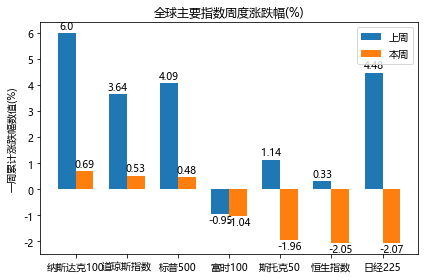

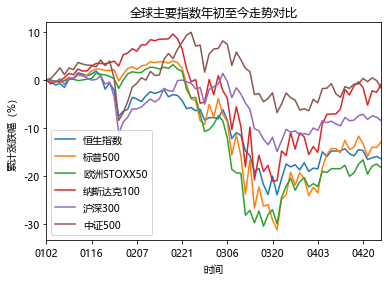

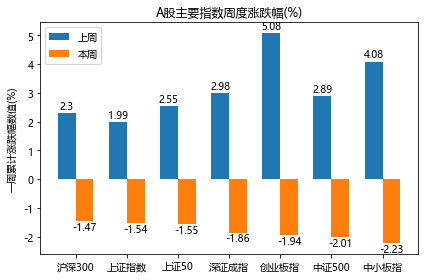

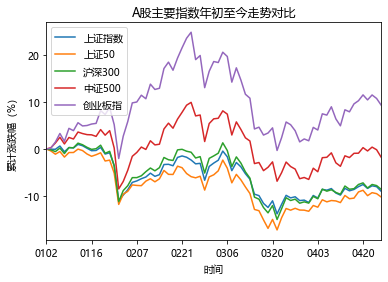

In [60]:
main()